# decline in oss participation

the decline of participation in the jupyterlab front ends community. there is data to demonstrate the attrition of people and organizations.

In [1]:
issues = pipe(
    # mapping of year to github issue
    """2024 229
2023 205
2023 170
2022 152
2022 135
2021 128
2021 117""", str.splitlines, 
    map(str.split), map(reversed), dict, Series
    ).to_frame("year").rename_axis("issue")
issues = issues.set_index(
    issues.index.map(
        "https://api.github.com/repos/jupyterlab/frontends-team-compass/issues/{}/comments?per_page=100".format
    )
)
issues = (await issues.index.http.get()).explode().series().join(issues).set_index("id")

transform issues bodies to html

In [2]:
issues = issues.assign(html=issues.body.apply(shell.tangle.parser.parser.render))
issues = issues.assign(soup=issues.html.apply(bs4.BeautifulSoup, features="lxml"))
issues = issues.assign(attendees=issues.html.apply(io.StringIO).apply(
    excepts(BaseException, pandas.read_html)
).apply(excepts(BaseException, get(0))))

do work on the dates so we can get them as numerical values

In [3]:
issues = issues.assign(
    date=issues.soup.methodcaller("select_one", "h1,h2,h3").dropna().attrgetter("contents").itemgetter(0).apply("".join)
)
issues.date = issues.date.str.split("(", expand=True)[0]
issues.date = (
    issues.date
    .str.removeprefix("JupyterLab Weekly Call, ")
    .str.removeprefix("JupyterLab Weekly Call - ")
    .str.removeprefix("Weekly Meeting")
    .str.removeprefix("Wednesday, ")
)

number_first =issues.date.str.lstrip().str.startswith(tuple(string.digits)).fillna(False)
issues.loc[number_first, "date"] = issues[number_first].apply(
    excepts(BaseException, lambda x: operator.itemgetter(1, 0, 2)(x.date.split())), axis=1
).apply(" ".join)

dates = issues.date.str.split().dropna().series(1)
dates[1] = dates[1].str.rstrip(","+string.ascii_letters)
noyear = dates[dates[2].isna()].index
dates[2] = issues.created_at.pipe(pandas.to_datetime).attrgetter("year").astype(str)
issues.loc[dates.index, "date"] = dates.fillna("").apply(" ".join, axis=1)
issues.date = issues.date.pipe(pandas.to_datetime, format="mixed")

/tmp/ipykernel_97782/3917024939.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  number_first =issues.date.str.lstrip().str.startswith(tuple(string.digits)).fillna(False)
/home/tbone/Documents/nobook/src/nobook/utils.py:259: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  return self.object.apply(pandas.Series, *args, **kwargs)


### total quarterly attendees

<Axes: xlabel='quarterly attendees'>

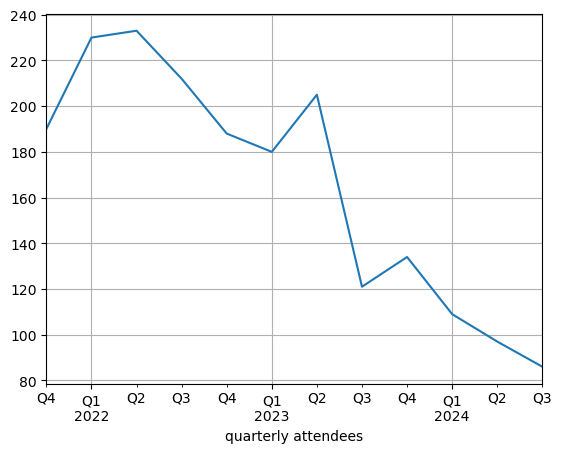

In [4]:
affiliation = issues[["date"]].join(
    pandas.concat(issues.attendees.to_dict()).rename_axis(("id", None), axis=0)
).set_index("date").dropna(subset="Name").Affiliation.str.lower().str.lstrip("@")

quarterly = affiliation.groupby(pandas.Grouper(freq="3ME")).count().iloc[1:]
quarterly.plot(xlabel="quarterly attendees", grid=True)

### top organization attendences

In [5]:
orgs = affiliation.groupby(pandas.Grouper(freq="6ME")).apply(Series.value_counts).unstack()
top = orgs.sum().sort_values().iloc[::-1].iloc[:15]
orgs = orgs.loc[:, top.index].fillna(0).iloc[1:]
orgs 

,quantstack,aws,ibm,quansight labs,quansight,bloomberg,anaconda,google,databricks,jp morgan chase,netflix,cocalc,engagelively,apple,oxford
date,,,,,,,,,,,,,,,
2022-07-31,77.0,45.0,66.0,30.0,13.0,16.0,10.0,24.0,19.0,15.0,14.0,12.0,6.0,4.0,9.0
2023-01-31,89.0,60.0,37.0,32.0,16.0,22.0,7.0,9.0,13.0,15.0,13.0,0.0,6.0,1.0,0.0
2023-07-31,86.0,58.0,12.0,29.0,27.0,20.0,14.0,2.0,10.0,8.0,7.0,1.0,2.0,1.0,0.0
2024-01-31,58.0,44.0,1.0,31.0,30.0,16.0,18.0,1.0,4.0,3.0,7.0,12.0,0.0,2.0,0.0
2024-07-31,43.0,36.0,1.0,19.0,16.0,15.0,26.0,0.0,0.0,0.0,2.0,6.0,0.0,2.0,0.0
